In [263]:
# For Kmeans algorithm. See PGM otherwise for handcrafted class
from sklearn.cluster import KMeans
# For loading matlab matrix file
from scipy.io import loadmat

from scipy.sparse.linalg import eigs
from scipy.stats import itemfreq
import numpy as np

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2
%precision %.5f
plt.rc('text', usetex=True)
plt.rc('font',**{'family':'serif','serif':['Palatino']})

# Globals

In [4]:
DATA_DIR = "data/"

# Data

In [272]:
YaleB = loadmat(DATA_DIR + 'ExtendedYaleB.mat')
data = YaleB['EYALEB_DATA']
ground_truth = YaleB['EYALEB_LABEL'].reshape(-1) - 1

# Functions

In [ ]:
def evaluate_error(predictions, ground_truth):
    """
    Evaluate error for all possible permuatations of n letters
    -----------------------------------------------------------------------------------
    Parameters :
    ------------
    predictions : list of size K1
                  labels predicted from a clustering algorithm
    ground_truth : list of size K2
                   true labels
    
    Returns :
    ---------
    Error : integer
    
    
    Sources :
    # 4.3.1
    http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.101.2605&rep=rep1&type=pdf
    # Other possible source
    https://www.r-bloggers.com/matching-clustering-solutions-using-the-hungarian-method/
    ------------------------------------------------------------------------------------
    """
    # Construct the Hungarian matrix
    

In [206]:
def gaussian_affinity(X, k, sigma, distance_matrix = None):
    """
    Construction of gaussian affinity with K-NN :
    w_{ij} = exp(-d_{ij}^2 / 2s^2) if NN 0 else
    
    Parameters :
    ------------
    X: array, shape [NxD]
       N data points
    k: positive integer
       number of nearest neighbors to consider
    sigma: positive integer
       standard deviation of the gaussian kernel
    
    Returns :
    ---------
    W: array, shape [NxN]
       affinity matrix
    
    """
    if distance_matrix is None:
#         # Care not to swap with this faster method (minimum RAM for YaleB : 32Gb)
#         A = np.tile(X, (X.shape[1], 1, 1)) - X.T.reshape(X.shape[1], -1, 1)
#         D = np.linalg.norm(A, axis = 1)

        # Awful method
        distance_matrix = np.array([np.linalg.norm(X - x.reshape(-1, 1), axis = 0)\
                                    for x in X.T])

        # No idea why D is not symetric
        distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)


    np.fill_diagonal(distance_matrix, np.inf)
    W = np.inf * np.ones(distance_matrix.shape)
    # Matrix of rank of nearest neighbors
    KNN = distance_matrix.argsort()[:, :k]
    for k,i in enumerate(KNN):
        if np.isin(k, KNN[i]):
            W[k, i] = distance_matrix[k, i]
    
    W = (W + W.T)/2

    return np.exp(-0.5 * (W / sigma) **2)

In [203]:
def SC(W, n, method = "full"):
    """
    Spectral Clustering algorithm.
    :param W: affinity matrix NxN (N : number of points)
    :param n: number of clusters
    :return : Segmentation of the data in n groups
    """
    # 1. Construct an affinity graph G with weight matrix W
    # 2. Compute the degree matrix D = diag(W1) and the Laplacian L = D - W
    D = np.diag(W.sum(axis = 1))
    L = D - W
    # 3. Compute the n eigenvectors of L associated with its n smallest eigenvalues
    ## May use scipy.sparse.linalg.eigs to speed up computation
    ## The vectors returned by linalg are normalized
    if method == "sparse":
        # SC(W, 10, method = "sparse")
        # 2 s ± 87.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
        evalues, evectors = eigs(L, k=n)
    else :
        # SC(W, 10, method = "full")
        # 37.5 s ± 2.61 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
        evalues, evectors = np.linalg.eig(L)
    # 4. Y : transpose of matrix of eigenvectors normalized by euclidien norm
    ## Y.shape = (N x n).T => n x N
    Y = evectors[:, -n:].T
    # 5. Cluster the points {y_j}_1^N into n groups using the K-means algorithm
    ## n_jobs controls the number of threads
    ## init with random as in algorithm 4.4
    kmeans = KMeans(n_clusters = n, n_jobs = -1, init = 'random').fit(Y.T)
    # Return the label for each point : not the exact segmentation as in algo 4.4
    return kmeans.labels_

# Test zone

In [36]:
data.shape

(2016, 2414)

In [148]:
#Distance matrix
#distance_matrix = np.array([np.linalg.norm(data - x.reshape(-1, 1), axis = 0) for x in data.T])
#distance_matrix = 0.5 * (distance_matrix + distance_matrix.T)

In [70]:
X = data[:, :100]

In [182]:
W = gaussian_affinity(data, 500, 10e3, distance_matrix = distance_matrix)
print ("Percentage of W filled : {}%".format((W > 0).sum() / len(W)**2 * 100))
W

Percentage of W filled : 13.232874512046203%


array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.82843906,  0.82971924],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.82334734,  0.82420835],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.82618802,  0.        ],
       [ 0.82843906,  0.82334734,  0.        , ...,  0.82618802,
         0.        ,  0.        ],
       [ 0.82971924,  0.82420835,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

/home/vmatthys/.local/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  


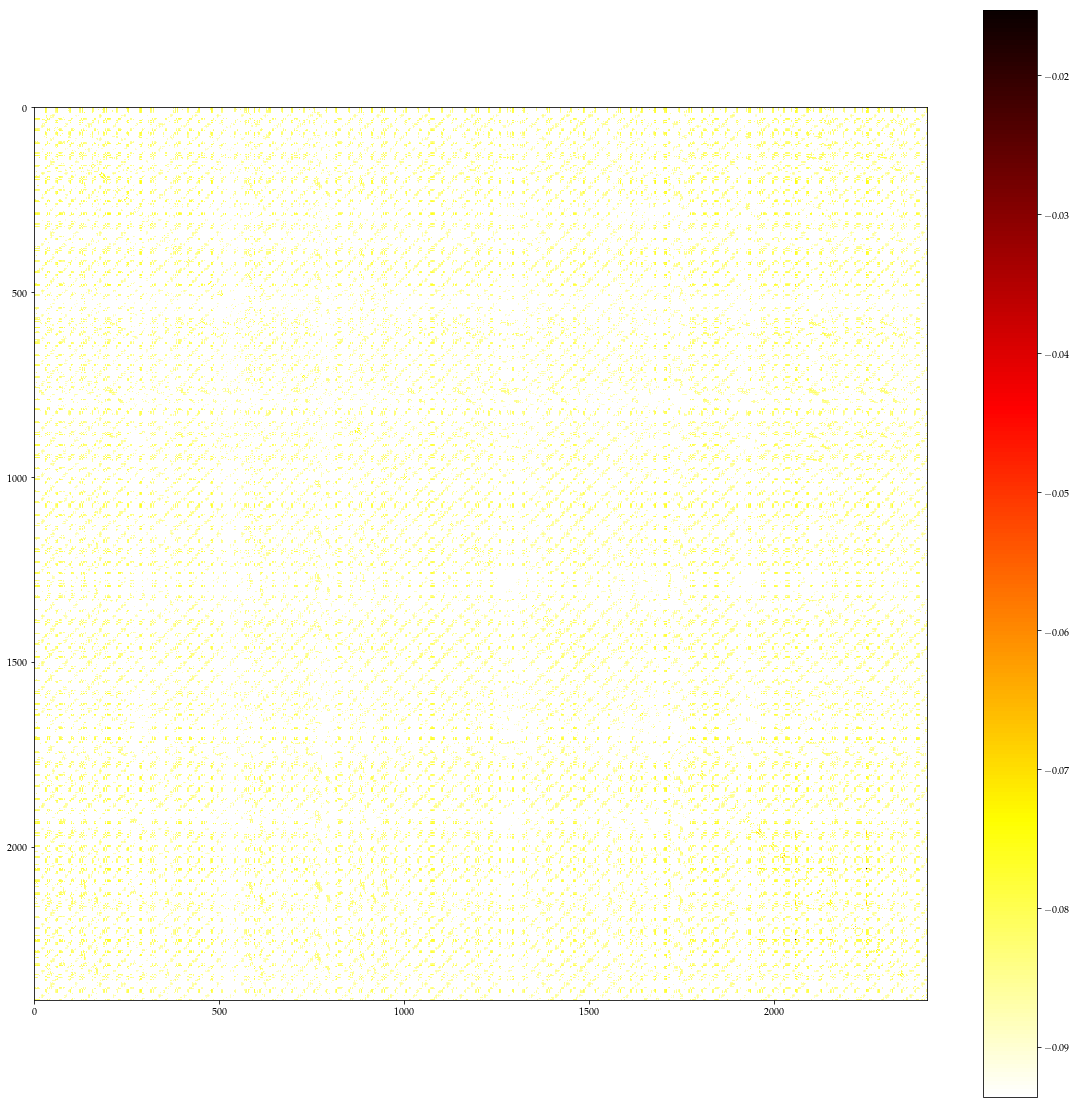

In [185]:
plt.figure(figsize= (20, 20))
plt.imshow(np.log10(W), cmap = "hot_r");
plt.colorbar();

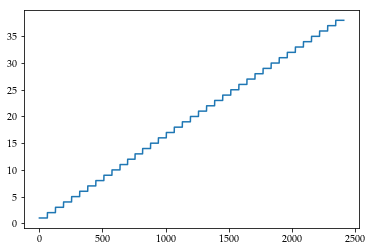

In [221]:
plt.plot(np.arange(ground_truth.shape[1]), ground_truth.T);

In [222]:
ground_truth

array([[ 1,  1,  1, ..., 38, 38, 38]], dtype=uint8)

In [223]:
from scipy.optimize import linear_sum_assignment

In [317]:
res = SC(W, 38, method = "sparse")

/usr/local/lib/python3.5/dist-packages/sklearn/utils/validation.py:402: ComplexWarning: Casting complex values to real discards the imaginary part
  array = np.array(array, dtype=dtype, order=order, copy=copy)


In [229]:
linear_sum_assignment(np.vstack((res.reshape(1, -1), ground_truth)))

(array([   0, 1642]), array([1, 0]))

In [227]:
np.vstack((res.reshape(1, -1), ground_truth))

array([[ 6, 14, 35, ..., 35, 16, 19],
       [ 1,  1,  1, ..., 38, 38, 38]], dtype=int32)

In [247]:
ground_truth[res == 5] == 10

array([False, False, False, False, False, False,  True,  True, False], dtype=bool)

In [318]:
T = np.zeros((38, 38))
for i in range(38):
    for j in range(0, 38):
        T[i,j] = (ground_truth[res == i] == j).sum()

In [324]:
linear_sum_assignment(T)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37]),
 array([32, 31, 35, 28, 23, 26,  1,  5,  2,  6,  7,  8,  0, 10, 11, 29,  9,
        13, 30, 14, 16, 15, 17, 18, 20, 12, 19, 33, 36, 21, 27,  3,  4, 22,
        24, 25, 34, 37]))

In [256]:
np.unique(res)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32)

In [320]:
res[:100]

array([36, 24,  4, 18, 36, 16, 24, 26, 24, 26, 24, 24, 26, 16,  7, 28,  4,
        4, 28, 25, 28, 25, 25, 25,  4, 28, 28, 28, 28,  4, 30,  9,  4, 18,
       18, 36, 10, 36, 35,  4, 31, 13, 16, 31,  5,  4,  4,  5, 32,  5,  5,
       32, 32,  4,  5,  5,  5,  4, 27,  6, 22, 27, 15, 20,  2,  2,  4, 30,
        2, 16,  2,  2,  2,  2, 24, 24, 16, 16, 24,  4,  4,  4, 16, 28, 28,
       25, 25, 28, 28, 28, 28, 28, 19,  4, 27, 30, 27, 18, 18,  2], dtype=int32)

In [321]:
itemfreq(res[:100])

array([[ 2,  8],
       [ 4, 16],
       [ 5,  7],
       [ 6,  1],
       [ 7,  1],
       [ 9,  1],
       [10,  1],
       [13,  1],
       [15,  1],
       [16,  7],
       [18,  5],
       [19,  1],
       [20,  1],
       [22,  1],
       [24,  8],
       [25,  6],
       [26,  3],
       [27,  4],
       [28, 14],
       [30,  3],
       [31,  2],
       [32,  3],
       [35,  1],
       [36,  4]])

In [279]:
ground_truth[130:180]

array([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2], dtype=uint8)

In [261]:
ground_truth[330:380]

array([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
       6, 6, 6, 6], dtype=uint8)

In [322]:
itemfreq(res[330:380])

array([[ 4, 11],
       [ 5, 10],
       [ 6,  2],
       [10,  1],
       [13,  1],
       [16,  1],
       [22,  1],
       [24,  1],
       [25,  4],
       [27,  3],
       [28, 10],
       [30,  1],
       [31,  2],
       [32,  1],
       [35,  1]])

In [323]:
itemfreq(res[130:180])

array([[ 4, 11],
       [ 5,  2],
       [ 6,  2],
       [ 7,  1],
       [10,  3],
       [13,  1],
       [16,  1],
       [18,  3],
       [22,  1],
       [23,  5],
       [24,  1],
       [25,  4],
       [28,  7],
       [30,  1],
       [31,  2],
       [32,  4],
       [36,  1]])